In [12]:
# %load genetic_algorithm_conversion_facebook.py
#!/usr/bin/env python

# In[4]:


import numpy as np
# from GAIndividual import GAIndividual
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import index_collector_conversion_facebook
sizepop, vardim, MAXGEN, params = 2000, 8, 15, [0.9, 0.1, 0.5]
DATABASE = "dev_facebook_test"
OBJECTIVE_LIST = [ 'CONVERSIONS', 'ADD_TO_CART', ]
COST_PER_ACTION = {
    'CONVERSIONS':'cost_per_purchase',
    'ADD_TO_CART':'cost_per_add_to_cart',
}

class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
        self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
        self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print("Optimal solution is:")
        print("m1--m2--m3--m4--m5--m6--mspend--mbid")
        print(self.best.chrom)
        self.printResult()
        return self.best.chrom
    
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] +                         (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()


class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] +                 (self.bound[1, i] - self.bound[0, i]) * rnd[i]
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = ObjectiveFunc.fitness_function( self.chrom, df )

class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''
    def __init__(self, campaign_id=None):
        self.mydb = index_collector_conversion_facebook.connectDB( DATABASE )
        
    def fitness_function(optimal_weight, df):
        charge_type = df['charge_type'].iloc[0]
        
        m1 = df['purchase'] / df['initiate_checkout']
        m2 = df['initiate_checkout'] / df['add_to_cart']
        m3 = df['add_to_cart'] / df['view_content']
        m4 = df['view_content'] / df['landing_page_view']
        m5 = df['landing_page_view'] / df['link_click']
        m6 = df['link_click'] / df['impressions']
        m_spend = -( df['daily_budget'] - df['spend'] ) / df['daily_budget']
        m_bid   = ( df['campaign_bid'] - df[ COST_PER_ACTION[charge_type] ] ) / df['campaign_bid']

        status  = np.array( [m1, m2, m3, m4, m5, m6, m_spend, m_bid] )
        status = np.nan_to_num(status)
        r = np.dot( optimal_weight, status )
        return r

    def adset_fitness(optimal_weight, df, charge_type):
        df = df.fillna(0)
        m1 = df['purchase'] / df['initiate_checkout']
        m2 = df['initiate_checkout'] / df['add_to_cart']
        m3 = df['add_to_cart'] / df['view_content']
        m4 = df['view_content'] / df['landing_page_view']
        m5 = df['landing_page_view'] / df['link_click']
        m6 = df['link_click'] / df['impressions']
        m_spend = -( df['daily_budget'] - df['spend'] ) / df['daily_budget']
        m_bid   = ( df['bid_amount'] - df[ COST_PER_ACTION[charge_type] ] ) / df['bid_amount']
        
        status  = np.array( [m1, m2, m3, m4, m5, m6, m_spend, m_bid] )
        for idx, j in enumerate(status[:,0]):
            if np.isinf(j) or np.isneginf(j):
                status[idx,0] = -100
        status = np.nan_to_num(status)
        r = np.dot( optimal_weight, status )
        return r
    
    def campaign_status( self, campaign_id ):
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        df_metrics = pd.read_sql("SELECT * FROM campaign_conversion_metrics WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        df_camp['campaign_bid'] = df_camp['spend_cap']/df_camp['target']
        self.charge_type = df_camp['charge_type'].iloc[0]

        spend = df_camp['spend'].iloc[0]
        campaign_cost_per_target = df_camp['cost_per_target'].iloc[0]
        campaign_target = df_camp['target'].iloc[0]
        impressions = df_camp['impressions'].iloc[0]
        df=pd.DataFrame(
            {
                'campaign_id':[ campaign_id ],
                'campaign_cost_per_target':[ campaign_cost_per_target ],
                'campaign_target':[ campaign_target ],
                'campaign_bid':[ df_camp['campaign_bid'].iloc[0] ],
                'daily_budget':[ df_camp['daily_budget'].iloc[0] ],
                'charge_type':[ df_camp['charge_type'].iloc[0] ]
            }
        )
        df = pd.merge( df, df_metrics, on=['campaign_id'] )
        df.fillna(value=0, inplace=True)
        df = df.convert_objects(convert_numeric=True)
        return df
    
    def adset_status( self, adset_id ):
        df=pd.DataFrame({'adset_id':[],'target':[], 'impressions':[], 'bid_amount':[]})

        df_adset = pd.read_sql("SELECT * FROM adset_conversion_metrics WHERE adset_id={} ORDER BY request_time DESC LIMIT 1".format(adset_id), con=self.mydb)
        df_adset.fillna(value=0, inplace=True)
        return df_adset

def ga_optimal_weight(campaign_id, df_weight):
    request_time = datetime.datetime.now().date()
    mydb = index_collector_conversion_facebook.connectDB( DATABASE )
#     df_weight = pd.read_sql("SELECT * FROM conversion_optimal_weight WHERE campaign_id={}".format(campaign_id), con=mydb)
    df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id={}".format(campaign_id), con=mydb)
    charge_type = df_camp['charge_type'].iloc[0]
    adset_list = index_collector_conversion_facebook.Campaigns(campaign_id, charge_type).get_adsets()
    for adset_id in adset_list:
        df = ObjectiveFunc().adset_status( adset_id )
        r = ObjectiveFunc.adset_fitness( df_weight, df, charge_type )
        print(r)
        df_final = pd.DataFrame({'campaign_id':campaign_id, 'adset_id':adset_id, 'score':r[0], 'request_time':request_time}, index=[0])

        index_collector_conversion_facebook.insertion("adset_score", df_final)

In [13]:
def main(campaign_id=None):
    starttime = datetime.datetime.now()
    global df
    if not campaign_id:
        campaign_list = index_collector_conversion_facebook.get_campaign_target()['campaign_id'].unique()
        for campaign_id in campaign_list:
            df = ObjectiveFunc().campaign_status(campaign_id)
            if df['charge_type'].iloc[0] in OBJECTIVE_LIST:

                print('campaign_id:', campaign_id )
                bound = np.tile([[0], [10]], vardim)
                ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
                optimal = ga.solve()
                score = ObjectiveFunc.fitness_function(optimal, df)
                weight_columns=['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w_spend', 'w_bid']
                df_weight = pd.DataFrame(data=[optimal], columns=weight_columns, index=[0])

                df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
                df_final = pd.concat( [df_weight, df_final], axis=1, sort=True, ignore_index=False)
                index_collector_conversion_facebook.check_optimal_weight(campaign_id, df_final)
                ga_optimal_weight(campaign_id, df_weight)
                print('optimal_weight:', optimal)
                print(datetime.datetime.now()-starttime)    
        print(datetime.datetime.now()-starttime)
    else:
        print('campaign_id:', campaign_id )
        print('current time: ', starttime )
        df = ObjectiveFunc().campaign_status(campaign_id)
        if df['charge_type'].iloc[0] in OBJECTIVE_LIST:

            print('campaign_id:', campaign_id )
            bound = np.tile([[0], [10]], vardim)
            ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
            optimal = ga.solve()
            score = ObjectiveFunc.fitness_function(optimal, df)
            weight_columns=['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w_spend', 'w_bid']
            df_weight = pd.DataFrame(data=[optimal], columns=weight_columns, index=[0])

            df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
            df_final = pd.concat( [df_weight, df_final], axis=1, sort=True, ignore_index=False)
            index_collector_conversion_facebook.check_optimal_weight(campaign_id, df_final)
            ga_optimal_weight(campaign_id, df_weight)
            print('optimal_weight:', optimal)
            print(datetime.datetime.now()-starttime)    
    print(datetime.datetime.now()-starttime)
    return

campaign_id: 23843467729120098
current time:  2019-05-16 17:49:26.527995
campaign_id: 23843467729120098


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:277: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Generation 0: optimal function value is: -0.993345; average function value is -0.987671
Generation 1: optimal function value is: 150.411718; average function value is 98.773422
Generation 2: optimal function value is: 150.411718; average function value is 105.707417
Generation 3: optimal function value is: 150.411718; average function value is 108.608145
Generation 4: optimal function value is: 150.411718; average function value is 110.726843
Generation 5: optimal function value is: 150.411718; average function value is 111.040363
Generation 6: optimal function value is: 150.411718; average function value is 111.381221
Generation 7: optimal function value is: 150.411718; average function value is 111.707068
Generation 8: optimal function value is: 150.411718; average function value is 111.957348
Generation 9: optimal function value is: 150.411718; average function value is 111.953546
Generation 10: optimal function value is: 150.411718; average function value is 111.650695
Generation 1

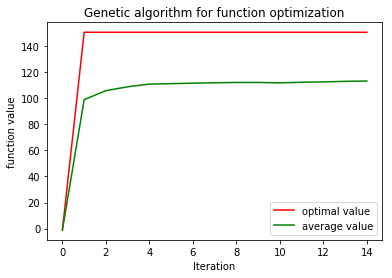

[[9.30542671]]
[[9.30542671]]
[[9.30542671]]
[[-963.87453476]]
[[-965.44954585]]
[[-964.18704409]]
[[-965.25613922]]
[[-964.37310006]]
[[-964.98966709]]
[[-960.09226829]]
[[-965.05173347]]
[[9.30542671]]
[[9.30542671]]
[[9.30542671]]
optimal_weight: [8.08625966 5.41967088 5.86933984 6.29983116 8.9756997  4.17838237
 9.86895484 9.30542671]
0:02:24.158851
0:02:24.158891


In [14]:
if __name__ == "__main__":
    main()
    import gc
    gc.collect()
#     main(23843467729120098)

In [15]:
!jupyter nbconvert --to script genetic_algorithm_conversion_facebook.ipynb

[NbConvertApp] Converting notebook genetic_algorithm_conversion_facebook.ipynb to script
[NbConvertApp] Writing 14866 bytes to genetic_algorithm_conversion_facebook.py
